In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
batsmen = pd.read_csv('IPL2023_Batsman.csv',  encoding='windows-1252')

Here we are computing two essential objective functions: Strike Rate and Average. These metrics serve as crucial performance indicators for a batsman.

In [ ]:
df = batsmen  # Replace 'your_data.csv' with the actual filename

# Step 3: Group the data by 'Batsman'
grouped = df.groupby('Batsman')

# Step 4: Calculate the required statistics
result = grouped.agg({
    'Run': 'sum',            # Total runs
    'Ball': 'sum',           # Total balls
    'match_no': 'nunique',   # Matches played (count unique match numbers)
    '4s': 'sum',             # Total 4s
    '6s': 'sum'              # Total 6s
}).reset_index()             # Reset the index to get 'Batsman' as a regular column

# Add a new column 'Not_Out' counting instances of 'Not Out' in 'out_by'
df['Not_Out'] = df['out_by'].apply(lambda x: 1 if x == 'Not Out' else 0)

# Group and sum the 'Not_Out' column for each player
not_out_counts = df.groupby('Batsman')['Not_Out'].sum().reset_index()

# Merge the not_out_counts with the result DataFrame
result = result.merge(not_out_counts, on='Batsman', how='left')
result['Strike_Rate'] = (result['Run'] / result['Ball']) * 100
# result['Average'] = result['Run'] / (result['match_no'] - result['Not_Out'])
# Calculate the 'Average' while avoiding division by zero
result['Average'] = result.apply(lambda row: row['Run'] / (row['match_no'] - row['Not_Out']) if (row['match_no'] - row['Not_Out']) != 0 else 0, axis=1)

# Rename columns for clarity
result.rename(columns={'match_no': 'Matches_Played', 'Not_Out': 'Not_Out_Count'}, inplace=True)

# Print the resulting DataFrame
result.head(10)


,Batsman,Run,Ball,Matches_Played,4s,6s,Not_Out_Count,Strike_Rate,Average
0,Abdul Basith,1,1,1,0,0,1,100.000000,0.000000
1,Abdul Samad,169,128,8,10,11,4,132.031250,42.250000
2,Abhinav Manohar,114,83,6,6,7,0,137.349398,19.000000
3,Abhishek Sharma,225,157,11,28,6,0,143.312102,20.454545
4,Abishek Porel,33,31,4,1,0,0,106.451613,8.250000
5,Adam Zampa,10,16,3,0,0,0,62.500000,3.333333
6,Adil Rashid,22,16,2,2,1,0,137.500000,11.000000
7,Aiden Markram,248,197,13,18,8,2,125.888325,22.545455
8,Ajinkya Rahane,282,166,9,22,13,1,169.879518,35.250000
9,Akash Deep,17,8,1,2,1,0,212.500000,17.000000


we are calculating two metrics to assess the model's performance:

Sum of Squares of Error (SSE) within clusters using the elbow method. Silhouette Score.

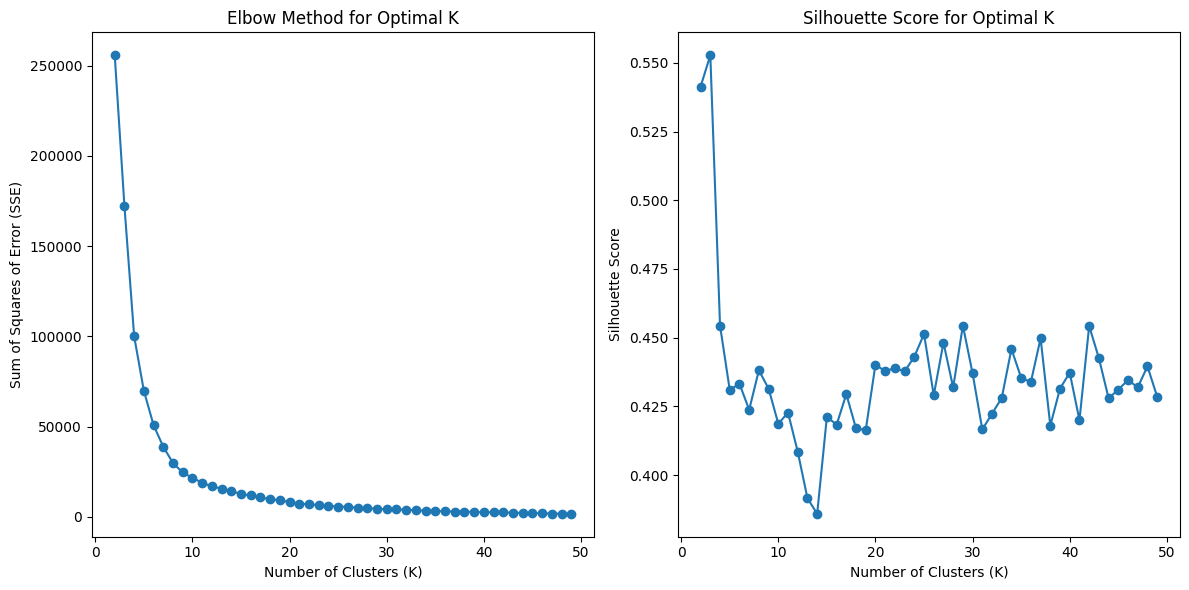

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# Extract the "Average" and "Strike_Rate" columns
X = result[["Average", "Strike_Rate"]]

# Initialize lists to store SSE and Silhouette scores
sse = []
silhouette_scores = []

# Try different values of K (number of clusters) to find the optimal K
K_range = range(2, 50)  # You can adjust this range as needed

for k in K_range:
    # Fit a KMeans model
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X)

    # Calculate SSE for this K
    sse.append(kmeans.inertia_)

    # Calculate Silhouette Score for this K
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot SSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squares of Error (SSE)')
plt.title('Elbow Method for Optimal K')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')

plt.tight_layout()
plt.show()


The Silhouette score for our clusters appears to be 12, as there is a significant drop from 12 to 13. Additionally, in the Elbow method, the value seems to level off after k = 12, indicating a plateau.

Here we are trying to fit gaussian distribution to our two objective function Average and Strike rate.

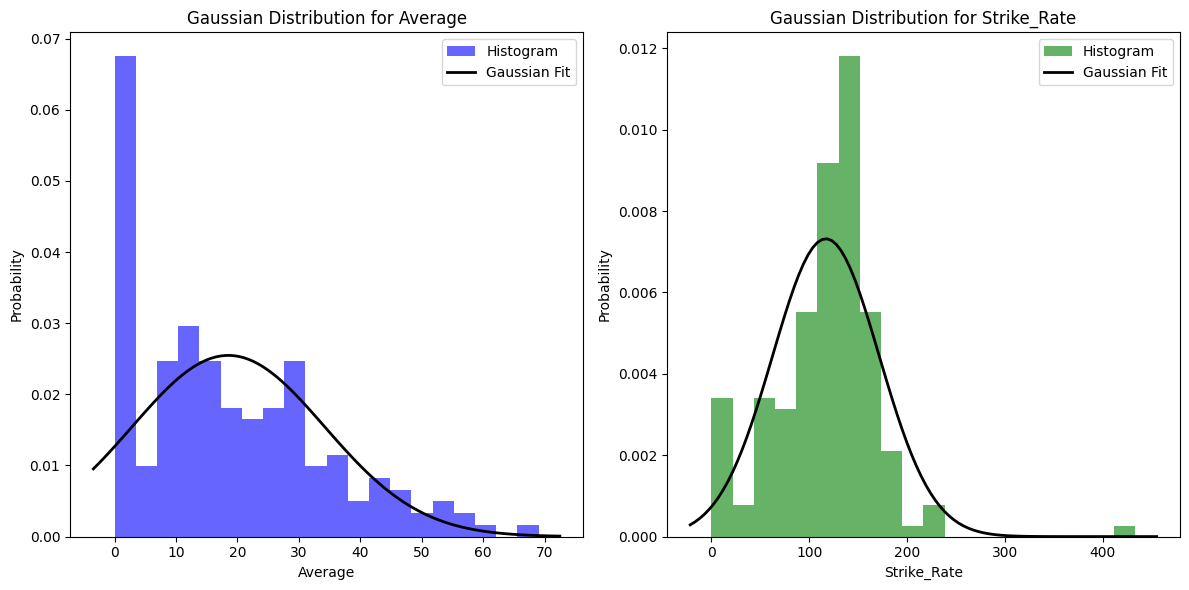

In [ ]:
from scipy.stats import norm

# Read the CSV file into a Pandas DataFrame


# Extract the "Average" and "Strike_Rate" columns
average_data = result["Average"]
strike_rate_data = result["Strike_Rate"]

# Create subplots for "Average" and "Strike_Rate"
plt.figure(figsize=(12, 6))

# Plot Gaussian distribution for "Average"
plt.subplot(1, 2, 1)
plt.hist(average_data, bins=20, density=True, alpha=0.6, color='b', label='Histogram')
mu, std = norm.fit(average_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
plt.xlabel('Average')
plt.ylabel('Probability')
plt.title('Gaussian Distribution for Average')
plt.legend()

# Plot Gaussian distribution for "Strike_Rate"
plt.subplot(1, 2, 2)
plt.hist(strike_rate_data, bins=20, density=True, alpha=0.6, color='g', label='Histogram')
mu, std = norm.fit(strike_rate_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
plt.xlabel('Strike_Rate')
plt.ylabel('Probability')
plt.title('Gaussian Distribution for Strike_Rate')
plt.legend()

plt.tight_layout()
plt.show()

In this section, we are applying k-means and Gaussian Mixture Model (GMM) clustering techniques with a value of 12 for the number of clusters.

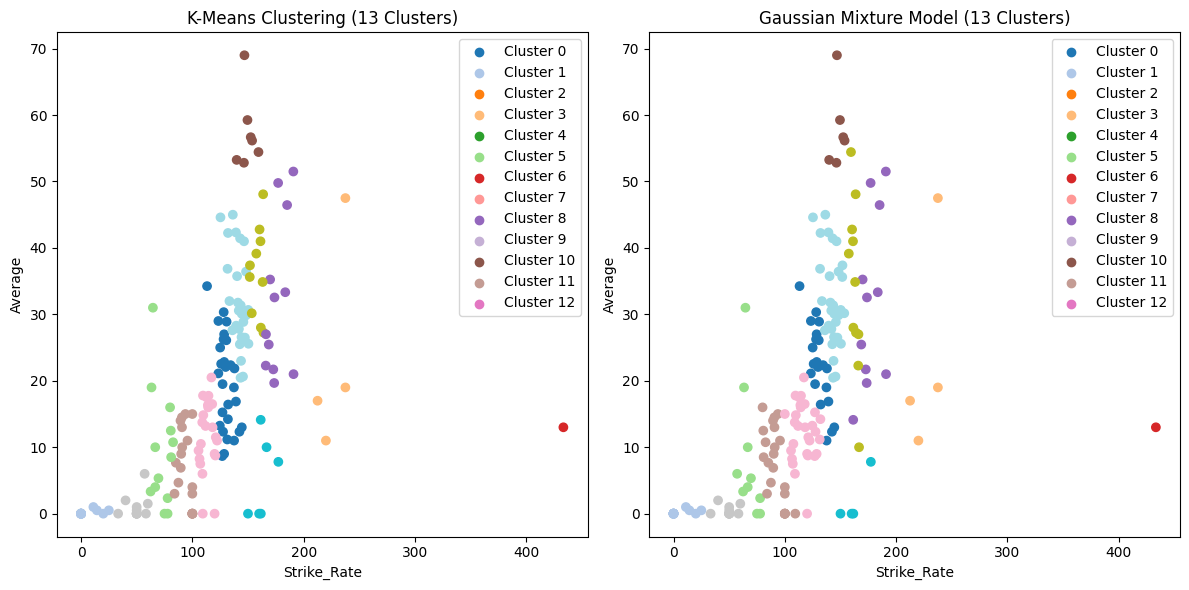

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


# Extract the "Average" and "Strike_Rate" columns
X = result[["Average", "Strike_Rate"]]

# Number of clusters
n_clusters = 13

# Fit K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Fit Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(X)

# Add K-Means cluster labels to DataFrame
result["KMeans_12_Cluster"] = kmeans_labels

# Add GMM cluster labels to DataFrame
result["GMM_12_Cluster"] = gmm_labels

# Define a colormap for clusters
cmap = plt.get_cmap('tab20')

# Create a scatter plot for K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X["Strike_Rate"], X["Average"], c=kmeans_labels, cmap=cmap)
plt.xlabel('Strike_Rate')
plt.ylabel('Average')
plt.title('K-Means Clustering ({} Clusters)'.format(n_clusters))

# Add color labels for K-Means clusters
for i in range(n_clusters):
    plt.scatter([], [], label='Cluster {}'.format(i), color=cmap(i))

plt.legend()

# Create a scatter plot for GMM
plt.subplot(1, 2, 2)
plt.scatter(X["Strike_Rate"], X["Average"], c=gmm_labels, cmap=cmap)
plt.xlabel('Strike_Rate')
plt.ylabel('Average')
plt.title('Gaussian Mixture Model ({} Clusters)'.format(n_clusters))

# Add color labels for GMM clusters
for i in range(n_clusters):
    plt.scatter([], [], label='Cluster {}'.format(i), color=cmap(i))

plt.legend()

plt.tight_layout()
plt.show()

 I conducted GMM and K-means clustering on our dataset with 12 clusters and generated a graph to visualize the similarities between the two methods. Upon examination, it appears that both techniques yield similar clustering results for our dataset.